In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from my_load import CPU_Unpickler
import pickle

# Load dataset
#ds_path = '../output/00024/dataset.pkl'
ds_path = '../output/FCC-organs/true_positive_aggregation/00004/dataset.pkl'  # <-- select patient here
with open(ds_path, 'rb') as f:
    ds = CPU_Unpickler(f).load()
    if isinstance(ds, DataLoader):
        ds = ds.dataset

# Extract tensors
X, y, w = (t.cpu() for t in ds.tensors)  # features, targets, sample weights
X_np, y_np, w_np = X.numpy(), y.numpy().ravel(), w.numpy().ravel()

print(f"Dataset shape: X={X_np.shape}, y={y_np.shape}, w={w_np.shape}")
print(f"Output range: [{y_np.min():.6f}, {y_np.max():.6f}]")
print(f"Weight range: [{w_np.min():.6f}, {w_np.max():.6f}]")

Dataset shape: X=(2000, 428), y=(2000,), w=(2000,)
Output range: [0.004220, 0.008796]
Weight range: [1.000000, 1000000.000000]


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit weighted linear regression
linreg = LinearRegression()
linreg.fit(X_np, y_np, sample_weight=w_np)

# Predictions
y_pred = linreg.predict(X_np)

# Metrics
mse = mean_squared_error(y_np, y_pred, sample_weight=w_np)
r2 = r2_score(y_np, y_pred, sample_weight=w_np)

print(f"Linear Regression - MSE: {mse:.6f}, R²: {r2:.6f}")
print("Learned weights:", linreg.coef_)
print("Intercept:", linreg.intercept_)

Linear Regression - MSE: 0.000000, R²: 0.999586
Learned weights: [-1.30085928e-05 -3.92497168e-06  1.14108545e-04 -1.35872164e-04
 -4.73104956e-05  2.27996366e-04 -8.34176535e-06  2.28671212e-04
  4.97643341e-05 -1.42375939e-05 -1.03361817e-05 -3.70581001e-05
  2.06134835e-04  3.51714443e-05 -1.96758963e-04 -3.63133295e-05
  2.96602579e-04 -1.04299812e-04 -9.47709341e-05 -1.17520700e-04
 -1.59000876e-04 -1.52515830e-04  2.03860851e-04 -5.52649726e-06
 -5.50147161e-05 -2.52355749e-05 -9.29341477e-05  2.36607448e-04
  7.74201908e-05  2.04124197e-04 -2.02360650e-04 -1.40351040e-04
  6.86027342e-05  2.99651656e-05  1.34007947e-04  3.20482432e-05
 -1.42244564e-04 -1.61624950e-04  1.62555603e-04  6.28312919e-05
 -1.44989230e-04  1.29513443e-04 -1.44546066e-04 -4.34642607e-05
 -1.47540530e-04 -1.93126209e-04  1.19891585e-04 -3.79605190e-05
 -1.06534171e-04 -3.27428861e-05  2.05386517e-04  1.68302067e-04
 -6.12930671e-05 -2.26880453e-04 -9.93612193e-05 -1.63295626e-05
 -8.93121469e-05  1.26709

In [3]:
import statsmodels.api as sm

# Add constant for intercept
X_sm = sm.add_constant(X_np)

# Weighted Least Squares (WLS) to include sample weights
model = sm.WLS(y_np, X_sm, weights=w_np)
results = model.fit()

print(results.summary())  # p-values, confidence intervals, and R²

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8860.
Date:                Fri, 05 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:38:51   Log-Likelihood:                 11977.
No. Observations:                2000   AIC:                        -2.310e+04
Df Residuals:                    1571   BIC:                        -2.069e+04
Df Model:                         428                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068   6.89e-07   9912.102      0.0

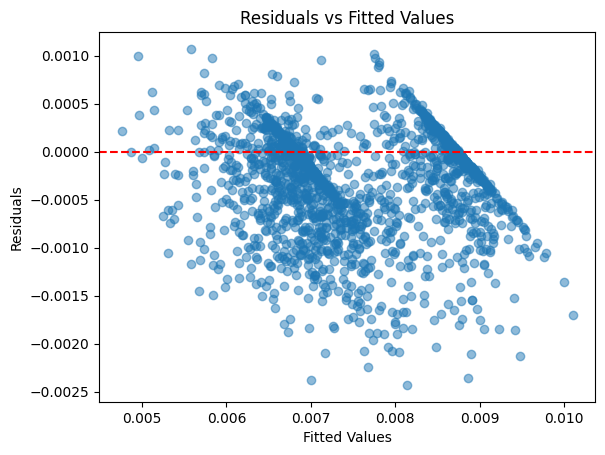

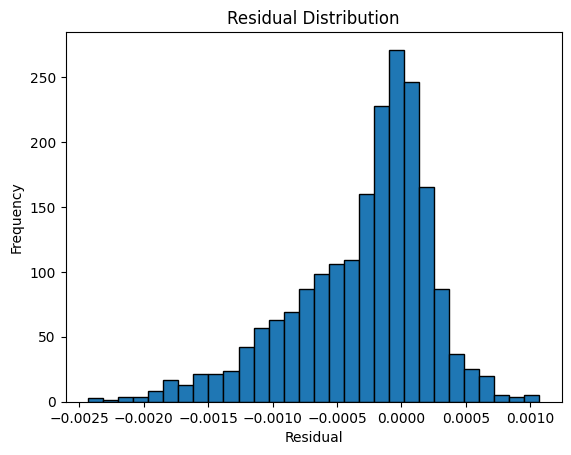

Shapiro-Wilk test: statistic=0.9442, p-value=0.0000
Residuals deviate from normality.


In [4]:
import matplotlib.pyplot as plt

residuals = y_np - y_pred

# Residuals vs Fitted
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Normality test of residuals
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p:.4f}")
if p > 0.05:
    print("Residuals look normally distributed.")
else:
    print("Residuals deviate from normality.")

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for i in range(X_np.shape[1]):
    vif = variance_inflation_factor(X_np, i)
    vif_data.append((f"Feature {i}", vif))

print("Variance Inflation Factors:")
for name, value in vif_data:
    print(f"{name}: {value:.2f}")

Variance Inflation Factors:
Feature 0: 11.65
Feature 1: 10.81
Feature 2: 10.70
Feature 3: 10.80
Feature 4: 10.21
Feature 5: 11.87
Feature 6: 10.98
Feature 7: 12.00
Feature 8: 13.18
Feature 9: 12.25
Feature 10: 11.62
Feature 11: 12.33
Feature 12: 10.30
Feature 13: 10.56
Feature 14: 11.72
Feature 15: 11.02
Feature 16: 11.04
Feature 17: 10.83
Feature 18: 11.41
Feature 19: 10.25
Feature 20: 11.06
Feature 21: 12.15
Feature 22: 11.37
Feature 23: 11.43
Feature 24: 11.59
Feature 25: 9.35
Feature 26: 10.72
Feature 27: 10.99
Feature 28: 11.29
Feature 29: 10.05
Feature 30: 10.81
Feature 31: 10.76
Feature 32: 11.53
Feature 33: 11.63
Feature 34: 10.60
Feature 35: 12.10
Feature 36: 10.34
Feature 37: 13.02
Feature 38: 11.28
Feature 39: 11.77
Feature 40: 11.32
Feature 41: 10.11
Feature 42: 10.45
Feature 43: 10.28
Feature 44: 10.64
Feature 45: 10.67
Feature 46: 11.41
Feature 47: 11.68
Feature 48: 11.45
Feature 49: 11.27
Feature 50: 12.14
Feature 51: 11.61
Feature 52: 12.12
Feature 53: 11.56
Feature 54:

In [6]:
from sklearn.linear_model import LassoCV

# Lasso with cross-validation
lasso = LassoCV(cv=5)
lasso.fit(X_np, y_np, sample_weight=w_np)

print("Lasso selected weights:", lasso.coef_)
print("Intercept:", lasso.intercept_)
print(f"Lasso R²: {lasso.score(X_np, y_np):.6f}")

/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.847e-07, tolerance: 2.007e-07
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.947e-07, tolerance: 2.007e-07
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing re

Lasso selected weights: [1.2463477e-03 3.9986221e-04 9.1593494e-05 0.0000000e+00 0.0000000e+00
 2.5876427e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.1547737e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e

/opt/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.110e-07, tolerance: 1.800e-07
  model = cd_fast.enet_coordinate_descent(


In [7]:
import pandas as pd
from IPython.display import display

# Parametri scelti da Lasso
lasso_selected = (lasso.coef_ != 0)

# Tabella regressione lineare
conf_int = results.conf_int()
coef_summary = pd.DataFrame({
    "Feature": [f"X{i}" for i in range(X_np.shape[1])],
    "OLS Coefficient": results.params[1:],  # skip intercept
    "p-value": results.pvalues[1:],
    "Conf. Int. Low": conf_int[1:, 0],
    "Conf. Int. High": conf_int[1:, 1],
    "Lasso Selected": lasso_selected,
})

# Colonna significatività statistica
coef_summary["Significativo (OLS)"] = coef_summary["p-value"] < 0.05

# Identificazione top 10 per valore assoluto dei coefficienti OLS
top_10_abs = coef_summary["OLS Coefficient"].abs().nlargest(10).index
coef_summary["Top 10 |OLS|"] = coef_summary.index.isin(top_10_abs)

# Funzione di evidenziazione
def highlight(val):
    return 'background-color: lightgreen' if val else ''

def highlight_top(val):
    return 'background-color: lightblue' if val else ''

# Applicazione evidenziazione multipla
styled = (coef_summary.style
          .map(highlight, subset=["Significativo (OLS)", "Lasso Selected"])
          .map(highlight_top, subset=["Top 10 |OLS|"]))

display(styled)

,Feature,OLS Coefficient,p-value,Conf. Int. Low,Conf. Int. High,Lasso Selected,Significativo (OLS),Top 10 |OLS|
0,X0,-0.000013,0.865244,-0.000159,0.000134,True,False,False
1,X1,-0.000005,0.950463,-0.000147,0.000138,True,False,False
2,X2,0.000113,0.119884,-0.000030,0.000256,True,False,False
3,X3,-0.000136,0.058196,-0.000277,0.000005,False,False,False
4,X4,-0.000048,0.492880,-0.000187,0.000090,False,False,False
5,X5,0.000228,0.003060,0.000077,0.000378,True,True,False
6,X6,-0.000009,0.904357,-0.000153,0.000135,False,False,False
7,X7,0.000229,0.002867,0.000079,0.000379,False,True,False
8,X8,0.000048,0.543793,-0.000107,0.000203,False,False,False
9,X9,-0.000014,0.855856,-0.000165,0.000137,False,False,False


In [8]:
# create an util to visualize a weight tensor showing the idx, value pairs
def visualize_weights(weights: torch.Tensor):
    length = weights.shape[0]
    idxs = torch.arange(length)

    print("torch.Tensor: ", [(f"{idx.item()}: {weight.item():.2e}") for idx, weight in zip(idxs, weights)])

In [11]:
 # Fit model with first n samples
from sklearn.linear_model import Lasso
surrogate = Lasso(alpha=0.0003, max_iter=10000)
n_samples = ds.__len__()  # use all samples
X_batch, y_batch, w_batch = next(iter(DataLoader(ds, batch_size=n_samples)))
surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())

# Get coefficients
phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
phi0 = surrogate.intercept_  # intercept
beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

print(f"Intercept (phi0): {phi0:.6f}")
print(f"Coefficients (phis): {visualize_weights(phis)}, shape={phis.shape}")

Intercept (phi0): 0.007429
torch.Tensor:  ['0: 0.00e+00', '1: 0.00e+00', '2: 0.00e+00', '3: 0.00e+00', '4: 0.00e+00', '5: 0.00e+00', '6: 0.00e+00', '7: 0.00e+00', '8: 0.00e+00', '9: 0.00e+00', '10: 0.00e+00', '11: 0.00e+00', '12: 0.00e+00', '13: 0.00e+00', '14: 0.00e+00', '15: 0.00e+00', '16: 4.12e-05', '17: 0.00e+00', '18: 0.00e+00', '19: 0.00e+00', '20: 0.00e+00', '21: 0.00e+00', '22: 0.00e+00', '23: 0.00e+00', '24: 0.00e+00', '25: 0.00e+00', '26: 0.00e+00', '27: 1.97e-07', '28: 0.00e+00', '29: 0.00e+00', '30: 0.00e+00', '31: 0.00e+00', '32: 0.00e+00', '33: 0.00e+00', '34: 0.00e+00', '35: 0.00e+00', '36: 0.00e+00', '37: 0.00e+00', '38: 0.00e+00', '39: 0.00e+00', '40: 0.00e+00', '41: 0.00e+00', '42: 0.00e+00', '43: 0.00e+00', '44: 0.00e+00', '45: 0.00e+00', '46: 0.00e+00', '47: 0.00e+00', '48: 0.00e+00', '49: 0.00e+00', '50: 0.00e+00', '51: 0.00e+00', '52: 0.00e+00', '53: 0.00e+00', '54: 0.00e+00', '55: 0.00e+00', '56: 0.00e+00', '57: 0.00e+00', '58: 0.00e+00', '59: 0.00e+00', '60: 0.

In [13]:
# sort features by mean value of y for each feature where X[:, i] != 0
n_features = X.shape[1]
mean_y = torch.zeros(n_features)
for i in range(n_features):
    mean_y[i] = y[X[:, i] != 0].mean() if (X[:, i] != 0).any() else -100000.0

sorted_indices_mean_y = torch.argsort(mean_y, descending=True)
print(f"Sorted indices by mean y: {sorted_indices_mean_y.tolist()}")

Sorted indices by mean y: [132, 80, 179, 112, 16, 211, 90, 106, 72, 167, 5, 247, 82, 284, 332, 194, 22, 188, 308, 27, 2, 113, 213, 28, 362, 222, 214, 89, 273, 279, 111, 168, 305, 223, 96, 130, 64, 120, 187, 129, 242, 370, 6, 50, 256, 424, 232, 13, 317, 29, 334, 7, 177, 39, 386, 303, 300, 57, 244, 103, 295, 321, 326, 376, 121, 18, 277, 393, 62, 98, 216, 236, 34, 414, 186, 59, 377, 162, 9, 51, 311, 357, 38, 391, 265, 304, 23, 100, 269, 48, 205, 32, 421, 402, 145, 260, 153, 388, 358, 12, 423, 361, 252, 293, 382, 248, 371, 41, 302, 262, 208, 354, 292, 237, 271, 47, 131, 141, 152, 301, 297, 125, 287, 119, 217, 344, 276, 406, 314, 312, 381, 55, 259, 296, 380, 1, 184, 309, 207, 209, 99, 138, 257, 275, 154, 166, 367, 133, 193, 175, 137, 171, 169, 135, 117, 102, 315, 274, 337, 355, 378, 37, 178, 412, 333, 49, 35, 161, 280, 245, 24, 92, 267, 215, 350, 77, 254, 390, 330, 231, 352, 218, 347, 418, 67, 173, 68, 243, 255, 426, 182, 203, 278, 181, 219, 407, 69, 401, 14, 238, 31, 206, 373, 249, 157, 0,

### first indices belong to the assumed most relevant supervoxels

In [14]:
# sort features by their coefficients
sorted_indices_coefs = torch.argsort(phis.abs(), descending=True)
print(f"Sorted indices by absolute value of coefficients: {sorted_indices_coefs.tolist()}")

Sorted indices by absolute value of coefficients: [132, 80, 90, 72, 16, 112, 27, 214, 427, 9, 10, 11, 12, 13, 14, 15, 7, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 6, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 5, 73, 74, 75, 76, 77, 78, 79, 4, 81, 82, 83, 84, 85, 86, 87, 88, 89, 3, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 2, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 1, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 

Feature 132 (mean y=0.008087) is ranked 1 in the coefficients position_in_coefs_ranking
Feature 80 (mean y=0.008066) is ranked 2 in the coefficients position_in_coefs_ranking
Feature 179 (mean y=0.008042) is ranked 180 in the coefficients position_in_coefs_ranking
Feature 112 (mean y=0.008042) is ranked 6 in the coefficients position_in_coefs_ranking
Feature 16 (mean y=0.008041) is ranked 5 in the coefficients position_in_coefs_ranking
Feature 211 (mean y=0.008038) is ranked 212 in the coefficients position_in_coefs_ranking
Feature 90 (mean y=0.008038) is ranked 3 in the coefficients position_in_coefs_ranking
Feature 106 (mean y=0.008035) is ranked 107 in the coefficients position_in_coefs_ranking
Feature 72 (mean y=0.008033) is ranked 4 in the coefficients position_in_coefs_ranking
Feature 167 (mean y=0.008031) is ranked 168 in the coefficients position_in_coefs_ranking


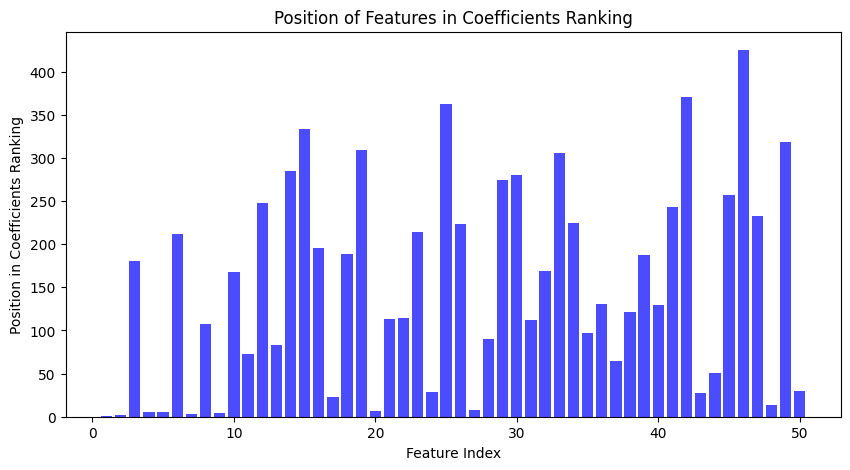

In [15]:
# draw the position of the highest ranked features according to the mean value of y, in the order of the coefficients
n_best = 10
for i in range(n_best):
    idx = sorted_indices_mean_y[i].item()
    position_in_coefs_ranking = (sorted_indices_coefs == idx).nonzero(as_tuple=True)[0].item()
    print(f"Feature {idx} (mean y={mean_y[idx].item():.6f}) is ranked {position_in_coefs_ranking + 1} in the coefficients position_in_coefs_ranking")

plot_first = 50
idx = sorted_indices_mean_y[:plot_first].numpy()
positions_in_coefs_ranking = [sorted_indices_coefs.tolist().index(i) + 1 for i in idx]
plt.figure(figsize=(10, 5))
plt.bar(range(1, plot_first+1), positions_in_coefs_ranking, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Position in Coefficients Ranking')
plt.title('Position of Features in Coefficients Ranking')
plt.show()